In [2]:
from keras_segmentation.models.unet import vgg_unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import imgaug as ia
import imgaug.augmenters as iaa
from scipy import stats

In [3]:
!ls

annotations			   my_tf_segmentation.ipynb
annotations_train_2		   preproc_img_2.ipynb
annotation_validation_2		   preproc_img.ipynb
border_detect.ipynb		   pspnet_50_train.ipynb
color_detect.ipynb		   segmentation_mobilenet.ipynb
color_detect_test.ipynb		   segmentation_test_model.ipynb
contour_detection_best_prac.ipynb  segm_mob_224_224.h5
data				   test_img
data.csv			   train_augmentation_2.ipynb
images_train_2			   train_augmentation.ipynb
model_upgrade.ipynb		   validation_2


In [4]:
data = pd.read_csv('data.csv')
data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,47,239,1280,273,1280,418,38,377,1,img00.jpg,1
1,37,400,1280,428,1280,882,26,872,2,img00.jpg,1
2,353,109,3465,141,3489,481,345,481,1,img01.jpg,1
3,329,533,3493,521,3569,1633,317,1781,2,img01.jpg,1
4,121,673,3869,633,3909,1057,105,1117,1,img02.jpg,1


In [12]:
for f in data.fname.unique():
    img = cv2.imread('data/'+f)
    seg = cv2.imread('annotations/'+f.split('.')[0]+'.png')
    img_r = cv2.resize(img, (224,224))
    seg_r = cv2.resize(seg, (224,224))
    cv2.imwrite('images_train_2/'+f.split('.')[0]+'.png',img_r)
    cv2.imwrite('annotations_train_2/'+f.split('.')[0]+'.png',seg_r)

In [5]:
def augment_seg(img,seg,seq):
    aug_det = seq.to_deterministic()
    image_aug = aug_det.augment_image(img)
    segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg)+1, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr_int()
    return image_aug, segmap_aug

def augmentation_images(images,annotations):
    """
    images = glob.glob('images_train_2/*.png')
    annotations = glob.glob('annotations_train_2/*.png')
    """
    
    img_path = images[0].split('/')[0]
    annot_path = annotations[0].split('/')[0]
    for i,s in zip(images,annotations):
    
        fname = i.split('/')[-1].split('.')[0]
        img = cv2.imread(i)
        seg = cv2.imread(s)

        for n in range(20):

            # crop augmentation
            bnds = np.random.randint(5,40,4)
            seq_crop = iaa.Sequential([iaa.Crop(px=tuple(bnds))])
            img_aug, seg_aug = augment_seg(img,seg,seq_crop)
            cv2.imwrite( img_path + '/'+fname+'_crop'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_crop'+str(n)+'.png',seg_aug)

            # rotate augmentation
            seq_rotate = iaa.Sequential([iaa.Affine(rotate=(-10,10))])
            img_aug, seg_aug = augment_seg(img,seg,seq_rotate)
            cv2.imwrite(img_path+'/'+fname+'_rotate'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_rotate'+str(n)+'.png',seg_aug)

            # scale augmentation
            seq_scale = iaa.Sequential([iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)})])
            img_aug, seg_aug = augment_seg(img,seg,seq_scale)
            cv2.imwrite(img_path+'/'+fname+'_scale'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_scale'+str(n)+'.png',seg_aug)

            # blur augmentation
            seq_blur = iaa.Sequential([iaa.GaussianBlur(sigma=(0, 3.0))])
            img_aug, seg_aug = augment_seg(img,seg,seq_blur)
            cv2.imwrite(img_path+'/'+fname+'_blur'+str(n)+'.png',img_aug)
            cv2.imwrite(annot_path+'/'+fname+'_blur'+str(n)+'.png',seg_aug)

In [13]:
images = glob.glob('images_train_2/*.png')
annotations = glob.glob('annotations_train_2/*.png')
augmentation_images(images,annotations)

/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)
/home/vasylcf/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:182: DeprecationWarning: Method `SegmentationMapsOnImage.get_arr_int()` is deprecated. Use `SegmentationMapsOnImage.get_arr()` instead.
  warn_deprecated(msg, stacklevel=3)


In [14]:
# create validation dataset
!mv images_train_2/img04*.png validation_2/
!mv images_train_2/img09*.png validation_2/
!mv annotations_train_2/img04*.png annotation_validation_2/
!mv annotations_train_2/img09*.png annotation_validation_2/

In [6]:
from keras_segmentation.models import unet

In [7]:
model = unet.mobilenet_unet(n_classes=4, input_height=224, input_width=224,)

Instructions for updating:
Colocations handled automatically by placer.


In [20]:
# model_2.train(
#     train_images =  "images_train_2/",
#     train_annotations = "annotations_train_2/",
#     validate = True,
#     val_images = "validation_2/",
#     val_annotations = "annotation_validation_2/",
#     epochs=5
# )

  8%|▊         | 55/648 [00:00<00:01, 544.26it/s]

Verifying training dataset


 33%|███▎      | 53/162 [00:00<00:00, 527.39it/s]

Dataset verified! 
Verifying validation dataset


100%|██████████| 162/162 [00:00<00:00, 529.06it/s]

Dataset verified! 
Starting Epoch  0
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/1
512/512 [==============================] - 57s 112ms/step - loss: 0.1152 - accuracy: 0.9640 - val_loss: 0.0613 - val_accuracy: 0.9705
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.0575 - val_accuracy: 0.9739
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0610 - val_accuracy: 0.9621
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0103 - accuracy: 0.9964 - val_loss: 0.3405 - val_accuracy: 0.9404
Finished Epoch 3
Starting Epoch  4
Epoch 1/1
512/512 [==============================] - 51s 100ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0692 - val_accuracy: 0.9686
Finished Epoch 4


In [21]:
#model.save('segm_mob_224_224.h5')

In [8]:
model.load_weights('segm_mob_224_224.h5')

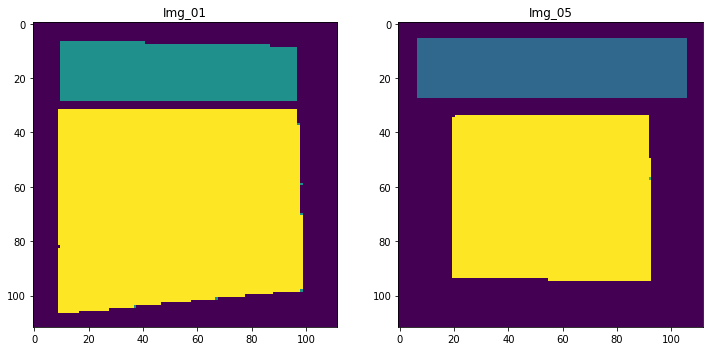

In [9]:
out_1 = model.predict_segmentation(inp="images_train_2/img01.png")
out_2 = model.predict_segmentation(inp="images_train_2/img05.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('Img_01')
plt.imshow(out_1)
plt.subplot(1,2,2)
plt.title('Img_05')
plt.imshow(out_2)

In [24]:
for f in ['test_1.jpg', 'test_2.jpg']:
    img = cv2.imread('test_img/'+f)
    img_r = cv2.resize(img, (224,224))
    cv2.imwrite('test_img/'+'mob_'+f.split('.')[0]+'.png',img_r)

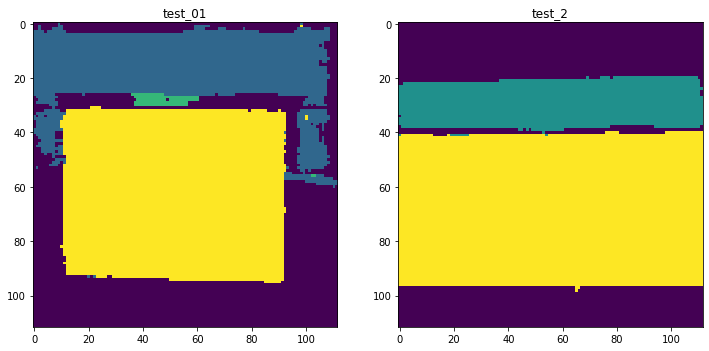

In [10]:
test_1 = model.predict_segmentation(inp="test_img/mob_test_1.png")
test_2 = model.predict_segmentation(inp="test_img/mob_test_2.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('test_01')
plt.imshow(test_1)
plt.subplot(1,2,2)
plt.title('test_2')
plt.imshow(test_2)

In [11]:
test_1.shape

(112, 112)

In [12]:
#out_1, out_2
#test_1, test_2

In [13]:
def find_segments(mask_img,cls,threshold=10):
    segments={}
    for cl in cls:
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_indecies = np.where(cols>=np.percentile(cols[cols>1],threshold))[0]
        row_indecies = np.where(rows>=np.percentile(rows[rows>1],threshold))[0]

        x1 = row_indecies[0]
        y1 = col_indecies[0]
        x2 = row_indecies[-1]
        y2 = col_indecies[-1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    
    return segments

In [14]:
def find_segments_2(mask_img,cls):
    segments={}
    for cl in cls:
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_indecies = np.where(cols>=np.mean(cols[cols>4])/2)[0]
        row_indecies = np.where(rows>=np.mean(rows[rows>4])/2)[0]

        x1 = row_indecies[0]
        y1 = col_indecies[0]
        x2 = row_indecies[-1]
        y2 = col_indecies[-1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    
    return segments

In [25]:
 def crop_rect_2(im, rect, scaler={'h': 1, 'w': 1}):
            return im[
                    rect[0][1]*scaler['h']:rect[1][1]*scaler['h'],
                    rect[0][0]*scaler['w']:rect[1][0]*scaler['w']
                ]

In [69]:
def detect_classes(img,n_classes):
    # result is better when we know names of classes
    labels, counts = np.unique(out_1,return_counts=True)
    labels = labels[1:]
    counts = counts[1:]
    inds = np.argsort(counts)
    list_classes = []
    for i in range(1,n_classes+1):
        list_classes.append(labels[inds[-i]])
    return list_classes

In [85]:
# TBD : add list_cls into dataset
# out_mask - mask that was returned by model (112*112)
# list_cls - list of classes on screenshort

#0OQ2DPLDB0, 0B550D1F2A
f='0OQ2DPLDB0.jpg'
img = cv2.imread('test_img/'+f)
img_r = cv2.resize(img, (224,224))

out = model.predict_segmentation(img_r)

h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
scaler = {'h': h_scale, 'w': w_scale, }

list_cls = [1,2]
rects = find_segments_2(out,list_cls)
segments = []
# coordinates will save in format [x, y, width, height]
for r in rects:
    segments.append({'label': r, 'data': crop_rect_2(img, rects[r], scaler=scaler), 'coordinates':rects[r]})

Find segments: 2


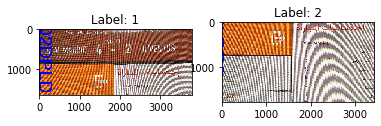

In [86]:
print(f'Find segments: {len(segments)}')
plt.subplot(1,2,1)
plt.title(f"Label: {segments[0]['label']}")
plt.imshow(segments[0]['data'])
plt.subplot(1,2,2)
plt.title(f"Label: {segments[1]['label']}")
plt.imshow(segments[1]['data'])
      

In [87]:
f='0B550D1F2A.jpg'
img = cv2.imread('test_img/'+f)
img_r = cv2.resize(img, (224,224))

out = model.predict_segmentation(img_r)

h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
scaler = {'h': h_scale, 'w': w_scale, }

list_cls = [1]
rects = find_segments_2(out,list_cls)
segments = []
for r in rects:
    segments.append({'label': r, 'data': crop_rect_2(img, rects[r], scaler=scaler), 'coordinates':rects[r]})

Find segments: 1


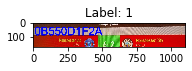

In [91]:
print(f'Find segments: {len(segments)}')
plt.subplot(1,2,1)
plt.title(f"Label: {segments[0]['label']}")
plt.imshow(segments[0]['data'])
# plt.subplot(1,2,2)
# plt.title(f"Label: {segments[1]['label']}")
# plt.imshow(segments[1]['data'])

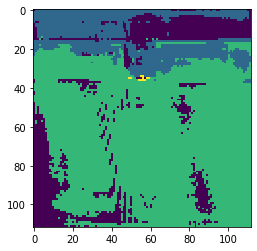

In [88]:
plt.imshow(out)

In [92]:
f='0B550D1F2A.jpg'
img = cv2.imread('test_img/'+f)
img_r = cv2.resize(img, (224,224))

out = model.predict_segmentation(img_r)

h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
scaler = {'h': h_scale, 'w': w_scale, }

list_cls = detect_classes(out,2)
rects = find_segments_2(out,list_cls)
segments = []
for r in rects:
    segments.append({'label': r, 'data': crop_rect_2(img, rects[r], scaler=scaler), 'coordinates':rects[r]})

Find segments: 2


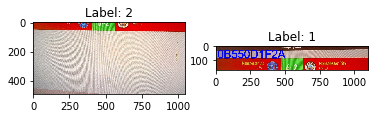

In [93]:
print(f'Find segments: {len(segments)}')
plt.subplot(1,2,1)
plt.title(f"Label: {segments[0]['label']}")
plt.imshow(segments[0]['data'])
plt.subplot(1,2,2)
plt.title(f"Label: {segments[1]['label']}")
plt.imshow(segments[1]['data'])

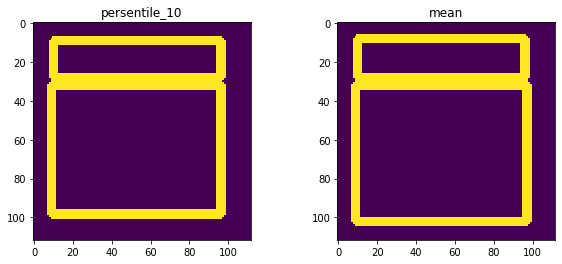

In [15]:
plt.figure(figsize=(10,4))
segments = find_segments(out_1,[1,2])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)
plt.subplot(1,2,1)
plt.title('persentile_10')
plt.imshow(m)
segments = find_segments_2(out_1,[1,2])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)

plt.subplot(1,2,2)
plt.title('mean')
plt.imshow(m)

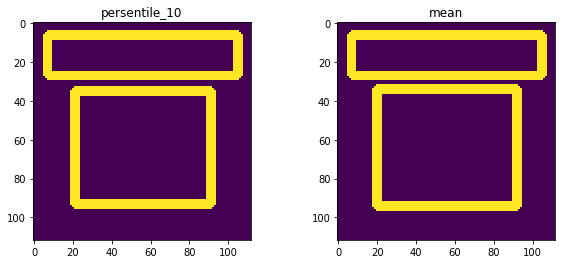

In [16]:
plt.figure(figsize=(10,4))
segments = find_segments(out_2,[1,3])
m = np.zeros(out_2.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)
plt.subplot(1,2,1)
plt.title('persentile_10')
plt.imshow(m)
segments = find_segments_2(out_2,[1,3])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)

plt.subplot(1,2,2)
plt.title('mean')
plt.imshow(m)

In [61]:
labels, counts = np.unique(out_1,return_counts=True)
labels = labels[1:]
counts = counts[1:]
inds = np.argsort(counts)
labels[ins[-1]]
labels[ins[-2]]

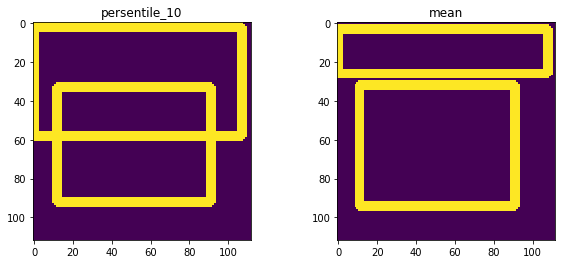

In [17]:
plt.figure(figsize=(10,4))
segments = find_segments(test_1,[1,3])
m = np.zeros(out_2.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)
plt.subplot(1,2,1)
plt.title('persentile_10')
plt.imshow(m)
segments = find_segments_2(test_1,[1,3])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)

plt.subplot(1,2,2)
plt.title('mean')
plt.imshow(m)

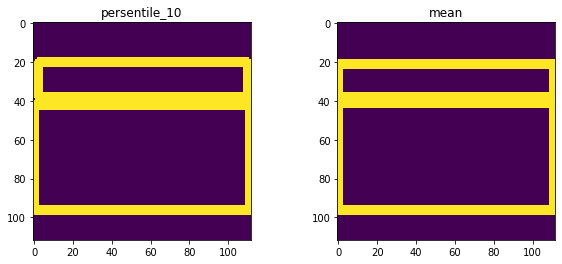

In [18]:
plt.figure(figsize=(10,4))
segments = find_segments(test_2,[1,2])
m = np.zeros(out_2.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)
plt.subplot(1,2,1)
plt.title('persentile_10')
plt.imshow(m)
segments = find_segments_2(test_2,[1,2])
m = np.zeros(out_1.shape)
for s in segments:
    cv2.rectangle(m,*segments[s],(255,255,0),3)

plt.subplot(1,2,2)
plt.title('mean')
plt.imshow(m)

(112.0, 0.0)

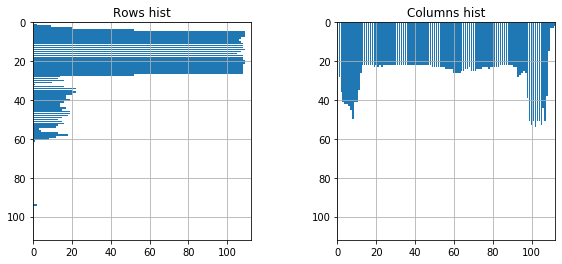

In [91]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Rows hist')
plt.axis([0,112,0,112])
plt.grid()
ax=plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_aspect('equal')
plt.barh(np.arange(1,113),rows,)
plt.subplot(1,2,2)
plt.title('Columns hist')
plt.bar(np.arange(1,113),cols)
plt.axis([0,112,0,112])
plt.grid()
ax=plt.gca()
ax.set_aspect('equal')
ax.set_ylim(ax.get_ylim()[::-1])

## Flow:
- contour detection
- sort contours by area
- select 2 the biggest contours
- convert them to rectangles
- calc intersection over union

In [23]:
RESIZE_WIDTH = 224
RESIZE_HEIGHT = 224
N_CLASSES_ON_IMAGE = 2

In [12]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

In [54]:
# crop roi
def crop_rect(im,cnt,scaler={'h':1,'w':1}):
    res = im[cnt[1]*scaler['h']:(cnt[1]+cnt[3])*scaler['h'],cnt[0]*scaler['w']:(cnt[0]+cnt[2])*scaler['w']]
    return res

# draw rectangle
def draw_rect(cnt):
    return (cnt[0],cnt[1]),(cnt[0]+cnt[2],cnt[1]+cnt[3]),(255,255,0),5

In [62]:
def predict_segmentation(img):
    
    cv2.imshow('Raw image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    img_resize = cv2.resize(img,(RESIZE_WIDTH, RESIZE_HEIGHT))
    
    cv2.imshow('resize image',img_resize)
    cv2.waitKey(0)
    cv2.destroyAllWindows()    
    
    out = model.predict_segmentation(img_resize)
    
    temp = np.zeros(out.shape)
    
    cv2.imshow('mask',(out*50).astype(np.uint8))
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    h_scale = int(np.round(img.shape[0]/out.shape[0],0))
    w_scale = int(np.round(img.shape[1]/out.shape[1],0))
    scaler={'h': h_scale, 'w':w_scale,}

    cnts, _ = cv2.findContours(out*10, cv2.RETR_FLOODFILL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=lambda x: cv2.contourArea(x), reverse=True)
    print(f'cnts: {len(cnts)}')
    rects = []
    k=1
    plt.figure(figsize=(12,4))
    for c in cnts[:5]:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(temp,*draw_rect([x,y,w,h]))
        rects.append([x,y,w,h])
        plt.subplot(1,5,k)
        plt.imshow(temp)
        k+=1
    
    print(f'rects: {len(rects)}')
    rects_ed, w = cv2.groupRectangles(rects,1,0.2)

    print(f'coordinates: {rects_ed}')

    if len(rects_ed)!= N_CLASSES_ON_IMAGE:
        #raise IndexError('the number of rectngles do not equal 2')
        print('the number of rectngles do not equal 2')

    segments = []
    # coordinates will save in format [x, y, width, height]
    for i in enumerate(rects_ed):
        segments.append({'label': i[0], 'data': crop_rect(img, i[1], scaler=scaler), 'coordinates': i[1]})
    return segments

cnts: 30
rects: 5
coordinates: ()
the number of rectngles do not equal 2


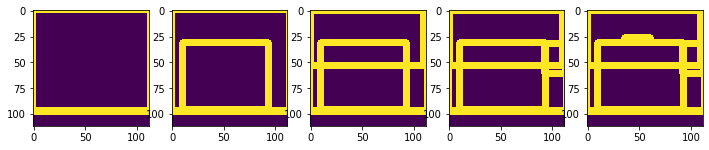

In [63]:
img = cv2.imread('test_img/test_1.jpg')
segments = predict_segmentation(img)

cnts: 6
rects: 5
coordinates: [[  2  46 110  57]
 [  4  28 109  22]]


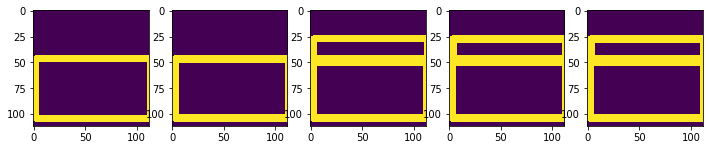

In [61]:
#img = cv2.imread('test_img/test_1.jpg')
img = cv2.imread('data/img00.jpg')
segments = predict_segmentation(img)

In [31]:
len(segments)

2

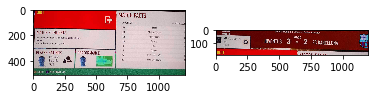

In [38]:
plt.subplot(1,2,1)
plt.imshow(segments[0]['data'])
plt.subplot(1,2,2)
plt.imshow(segments[1]['data'])